### 相對比較認真地 mask 過後的東西
做 HCN/CO 的 ratio map

前置處理真的是耗盡全力...但依然不能說 mask 得很好  
幹  
基礎的卷積，但在做ratio map 的時候新增了**撇去浮沫**這個東西  
應該會讓我在用 CARTA 的時候方便一點


可以輸入東西：  
1. CO_Nsigma, HCN_Nsigma : 可以快速換換分別要幾個 sigma 的
2. pixelStep : 投影後的一個像素對應天上多少角秒
3. beamPara = [] : 長短軸和傾角

檔案名稱變成浮動式的！全部匯集在最下面

In [50]:
# modular

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u 
from astropy.convolution import convolve_fft
from reproject import reproject_interp
from radio_beam import Beam

In [51]:
# hand made function

def Save_as_FITS(the_file_name, ima_data, ref_header, ref_beam, beam_a_Beam): # 存檔芝士
    the_file_name = the_file_name + '.fits'
    the_header = ref_header.copy() # new header 是複製一個已知 header 的大部分...
    if beam_a_Beam == True: # ref_beam 是實際意義上的 Beam 的話
        the_header['BMAJ'] = ref_beam.major.to(u.deg).value
        the_header['BMIN'] = ref_beam.minor.to(u.deg).value
        the_header['BPA'] = ref_beam.pa.to(u.deg).value
    else: # ref_beam 是一個 header 的話
        the_header['BMAJ'] = ref_beam['BMAJ']
        the_header['BMIN'] = ref_beam['BMIN']
        the_header['BPA'] = ref_beam['BPA']
    fits.writeto(the_file_name, ima_data, the_header, overwrite=True)
    print(f'Successfully saved a new FITS file as {the_file_name}')


# 新網格機！
'''
input a hdul&&像素步長 in arcsec
return new_shape, new_wcs, 和定義的 header 本人 
'''
def reGrid(reGrid_obj, pixelStep_target): 
    reGrid_obj_header = reGrid_obj[0].header
    ori_n1, ori_n2 = reGrid_obj[0].data.squeeze().shape # (y, x)
    new_n2 = int(ori_n2*abs(reGrid_obj_header['CDELT1']) / (pixelStep_target/3600)) # 要純量相除！
    new_n1 = int(ori_n1*abs(reGrid_obj_header['CDELT2']) / (pixelStep_target/3600))
    new_header = fits.Header()
    new_header['NAXIS'] = 2
    new_header['NAXIS1'] = new_n2
    new_header['NAXIS2'] = new_n1
    new_header['CRPIX1'] = new_n2 * 0.5 + 1
    new_header['CRPIX2'] = new_n1 * 0.5 + 1
    new_header['CRVAL1'] = 213.2915 # 暴力抓蟲
    new_header['CRVAL2'] = -65.339 # 暴力抓蟲
    new_header['CDELT1'] = pixelStep_target / -3600
    new_header['CDELT2'] = pixelStep_target / 3600
    new_header['CTYPE1'] = 'RA---SIN'
    new_header['CTYPE2'] = 'DEC--SIN'
    new_header['CUNIT1'] = 'deg'
    new_header['CUNIT2'] = 'deg'
    new_header['BMAJ'] = reGrid_obj_header['BMAJ']
    new_header['BMIN'] = reGrid_obj_header['BMIN']
    new_header['BPA'] = reGrid_obj_header['BPA']
    print('Giving reprojecting material...')
    return (new_n2, new_n1), WCS(new_header), new_header

In [52]:
# import data

CO_Nsigma, HCN_Nsigma = (2.2, 4.2) # 這邊可以快速換換分別要幾個 sigma 的
CO_hdul = fits.open(f"/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/mvpData/CO(1-0)_mom0_{CO_Nsigma}sigma.fits")
HCN_hdul = fits.open("/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/mvpData/HCN(1-0)_mom0_"+str(HCN_Nsigma)+"sigma.fits")

CO_header, HCN_header = CO_hdul[0].header, HCN_hdul[0].header 
CO_ima, HCN_ima = CO_hdul[0].data.squeeze(), HCN_hdul[0].data.squeeze()
CO_wcs, HCN_wcs = WCS(CO_header, naxis=2), WCS(HCN_header, naxis=2)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [53]:
# regridding

pixelStep = 1.0 # arcsec
CO_new_shape, CO_new_wcs, CO_new_header = reGrid(CO_hdul, pixelStep)
CO_ima_reproj, _ = reproject_interp((CO_ima, CO_wcs), CO_new_wcs, shape_out=CO_new_shape)
HCN_ima_reproj, _ = reproject_interp((HCN_ima, HCN_wcs), CO_new_wcs, shape_out=CO_new_shape) # 寄生

HCN_new_header = CO_new_header.copy()
HCN_header['BMAJ'] = HCN_header['BMAJ']
HCN_header['BMIN'] = HCN_header['BMIN']
HCN_header['BPA'] = HCN_header['BPA']


Giving reprojecting material...


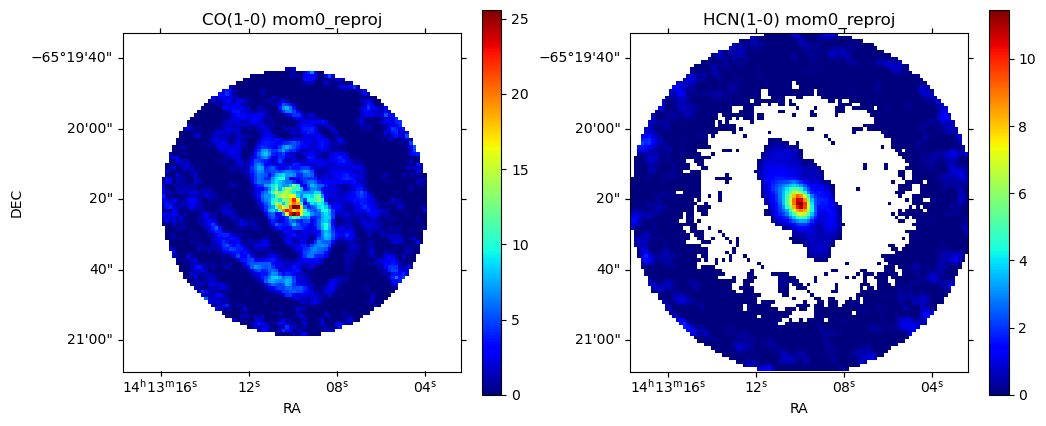

In [54]:
# show the regrid ima

fig_rg, ax = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': CO_new_wcs}) # 是這樣設座標的
im1 = ax[0].imshow(CO_ima_reproj, cmap='jet', vmin=0) # 要指定物件
fig_rg.colorbar(im1, ax=ax[0]) # call the obj
ax[0].set_title("CO(1-0) mom0_reproj")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
im2 = ax[1].imshow(HCN_ima_reproj, cmap='jet', vmin=0)
fig_rg.colorbar(im2, ax=ax[1]) 
ax[1].set_title("HCN(1-0) mom0_reproj")
ax[1].set_xlabel('RA')
ax[1].set_ylabel(' ')
#ax[1].set_ylabel('DEC')
plt.show()

In [55]:
# convole to a manmade beam

CO_beam, HCN_beam = Beam.from_fits_header(CO_header), Beam.from_fits_header(HCN_header) # 原始束寬應該和投影過後的束寬一樣
pixelScale = pixelStep*u.arcsec ## 不知道是不是這樣寫
beamPara = [3, 3, 0] # BMAJ, BMIN, BPA
tarBeam = Beam(major=beamPara[0]*u.arcsec, minor=beamPara[1]*u.arcsec, pa=beamPara[2]*u.deg)
bb = f'{beamPara[0]}{beamPara[0]}' # for fileName
kernel = tarBeam.as_kernel(pixscale=pixelScale)
CO_ima_final = convolve_fft(CO_ima_reproj, kernel)
HCN_ima_final = convolve_fft(HCN_ima_reproj, kernel)

print('initial beams:')
print('CO ', CO_beam)
print('HCN', HCN_beam)
print("THE", tarBeam)
print()
print(f"kernel shape: {kernel.shape}")
print(f"image shape: {CO_new_shape}")
print('** if ur kernel is so much bigger than image, you will get 一坨 :-(')
print()
print('Successfully convolved the image !')


initial beams:
CO  Beam: BMAJ=1.6457359820634 arcsec BMIN=1.01729727165636 arcsec BPA=73.02849492285 deg
HCN Beam: BMAJ=4.4068285951056 arcsec BMIN=3.53323497694104 arcsec BPA=40.60257850668 deg
THE Beam: BMAJ=3.0 arcsec BMIN=3.0 arcsec BPA=0.0 deg

kernel shape: (21, 21)
image shape: (96, 96)
** if ur kernel is so much bigger than image, you will get 一坨 :-(

Successfully convolved the image !


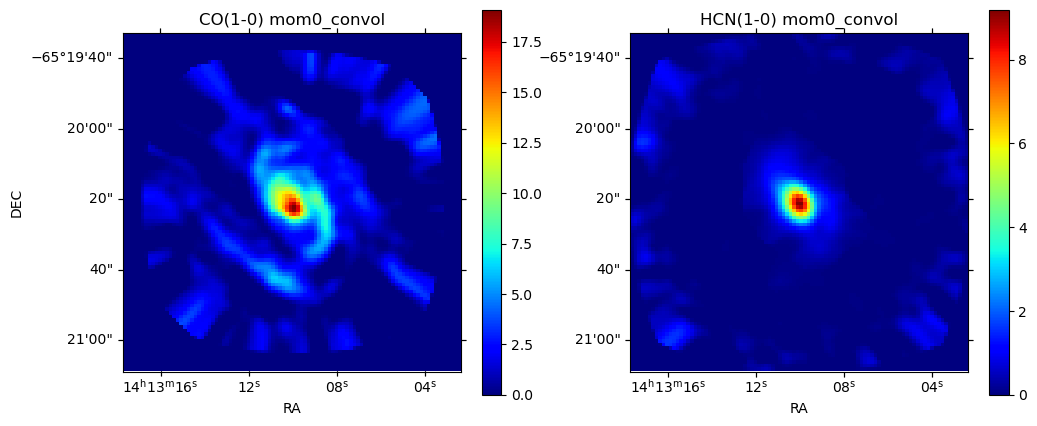

In [56]:
# show the convoled imaa

fig_cv, ax = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': CO_new_wcs})
im1 = ax[0].imshow(CO_ima_final, cmap='jet', vmin=0)
fig_cv.colorbar(im1, ax=ax[0])
ax[0].set_title("CO(1-0) mom0_convol")
ax[0].set_xlabel('RA')
ax[0].set_ylabel('DEC')
im2 = ax[1].imshow(HCN_ima_final, cmap='jet', vmin=0)
fig_cv.colorbar(im2, ax=ax[1]) 
ax[1].set_title("HCN(1-0) mom0_convol")
ax[1].set_xlabel('RA')
ax[1].set_ylabel(' ')
plt.show()

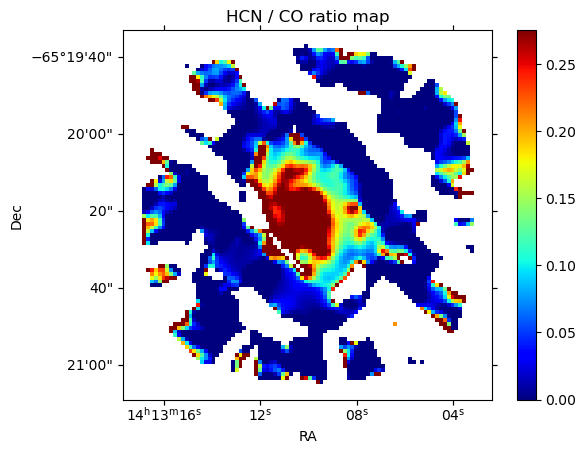

In [62]:
# ratio map
with np.errstate(divide='ignore', invalid='ignore'): 
    ratioMap = np.where(CO_ima_final>2*10**(-3), HCN_ima_final/CO_ima_final, np.nan)
    #ratioMap = np.where(CO_ima_final!=0, HCN_ima_final/CO_ima_final, np.nan)
    ratioMap = np.where(ratioMap>2.3, np.nan, ratioMap) # 撇掉一些浮沫
    ratioMap = np.where(ratioMap<-4, np.nan, ratioMap) 

plt.figure(4)
plt.subplot(projection=CO_new_wcs)
plt.imshow(ratioMap, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ratioMap, 90))
#plt.imshow(ratioMap, cmap='jet') #inferno
#plt.imshow(ratioMap, origin='lower', cmap='jet', vmin=0, vmax=0.28)
plt.title("HCN / CO ratio map")
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [63]:
# save all file

# regrid
Save_as_FITS(f'CO(1-0)_mom0_{CO_Nsigma}sigma_regrid{pixelStep}', CO_ima_reproj, CO_new_header, CO_new_header, False)
Save_as_FITS(f'HCN(1-0)_mom0_{HCN_Nsigma}sigma_regrid{pixelStep}', HCN_ima_reproj, CO_new_header, HCN_new_header, False)

# convel
Save_as_FITS(f'CO(1-0)_mom0_{CO_Nsigma}sigma_regrid{pixelStep}_beam{bb}', CO_ima_final, CO_new_header, tarBeam, True)
Save_as_FITS(f'HCN(1-0)_mom0_{HCN_Nsigma}sigma_regrid{pixelStep}_beam{bb}', HCN_ima_final, HCN_new_header, tarBeam, True)

# ratio
Save_as_FITS(f"HCN-CO_ratio_sigma{HCN_Nsigma}-{CO_Nsigma}_regrid{pixelStep}_beam{bb}", ratioMap, CO_new_header, tarBeam, True)

Successfully saved a new FITS file as CO(1-0)_mom0_2.2sigma_regrid1.0.fits
Successfully saved a new FITS file as HCN(1-0)_mom0_4.2sigma_regrid1.0.fits
Successfully saved a new FITS file as CO(1-0)_mom0_2.2sigma_regrid1.0_beam33.fits
Successfully saved a new FITS file as HCN(1-0)_mom0_4.2sigma_regrid1.0_beam33.fits
Successfully saved a new FITS file as HCN-CO_ratio_sigma4.2-2.2_regrid1.0_beam33.fits
